In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import facenet_pytorch as fn

In [2]:
mtcnn = fn.MTCNN(select_largest=False, device='cpu')
mtcnn

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

In [3]:
cap.get(7)

NameError: name 'cap' is not defined

(-0.5, 639.5, 479.5, -0.5)

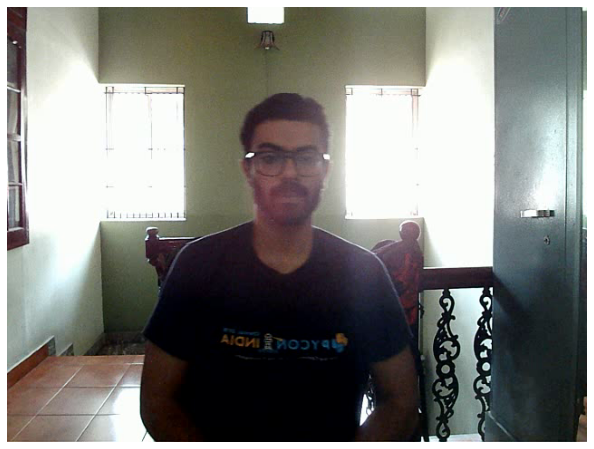

In [4]:
cap = cv2.VideoCapture('output.avi')
cap.set(1, 120)
success, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')



In [176]:
face, probs, landmarks = mtcnn.detect(Image.fromarray(frame), 
                                      landmarks=True)
landmarks

array([[[291.61478, 165.47543],
        [331.75635, 164.94792],
        [310.47757, 189.5627 ],
        [291.9878 , 207.44296],
        [327.56354, 207.76884]]], dtype=float32)

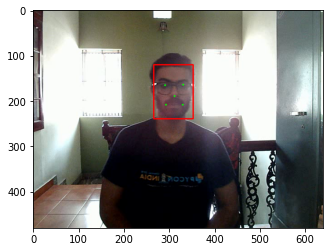

In [82]:
x1, y1, x2, y2 = face.squeeze()
cv2.rectangle(frame, (x1, y1),
              (x2, y2), (255, 0, 0), 2)
for point in landmarks.squeeze():
    x, y = point
    cv2.circle(frame, (x, y), radius=2, 
              color=(0, 255, 0), thickness=-1)
plt.imshow(frame)

## HAAR cascade classifier

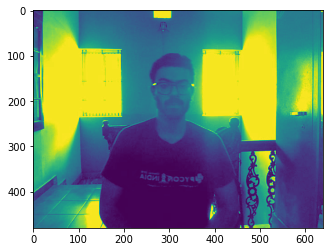

In [87]:
cascPath = 'haarcascade_frontalface_default.xml'

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cascPath)

plt.imshow(gray)

In [90]:
gray.shape

(480, 640)

In [93]:
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)
faces

array([[257, 126, 104, 104]], dtype=int32)

In [95]:
for face in faces:
    x, y, h, w = face
    cv2.rectangle(frame, (x, y),
              (x+w, y+h), (255, 0, 0), 2)

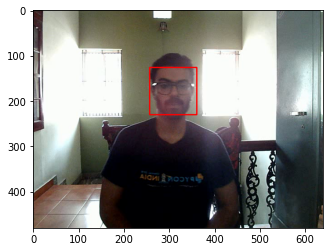

In [96]:
plt.imshow(frame)

In [112]:
frame.shape[1::-1]

(640, 480)

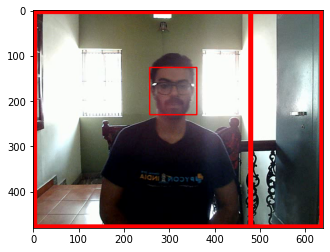

In [113]:
# mark matched!
cv2.rectangle(frame, (0, 0),
              frame.shape[1::-1], (255, 0, 0), 15)
plt.imshow(frame)

In [106]:
frame.shape

(480, 640, 3)

## Verification

In [5]:
resnet = fn.InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = fn.MTCNN(margin=14, keep_all=True, factor=0.5).eval()

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets

from collections import defaultdict

In [42]:
class Matcher:
    def __init__(self, path):
        dataset = datasets.ImageFolder(path)
        dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
        self.idx_to_class = dataset.idx_to_class
        self.class_to_idx = dataset.class_to_idx
        self.loader = DataLoader(dataset, collate_fn=self.collate_fn)
        self.resnet = fn.InceptionResnetV1(
            pretrained='vggface2').eval()
        self.mtcnn = fn.MTCNN(
                image_size=160, margin=0, min_face_size=20,
                thresholds=[0.6, 0.7, 0.7], factor=0.709, 
                post_process=True
            )
        
        self.matcher_db = self.init_matcher_db()
        
    @staticmethod
    def collate_fn(x):
        return x[0]
    
    def init_matcher_db(self):
        aligned = []
        names = []
        matcher_db = defaultdict(list)
        
        for x, y in self.loader:
            x_aligned, prob = self.mtcnn(x, return_prob=True)
            if x_aligned is not None:
                aligned.append(x_aligned)
                names.append(self.idx_to_class[y])
                
        aligned = torch.stack(aligned)
        embeddings = self.resnet(aligned)
        
        for name, emb in zip(names, embeddings):
            matcher_db[name].append(emb)
            
        return matcher_db
    
    def recognize(self, img):
        """
        img: takes image as numpy array
        """
        face, prob = self.mtcnn(img, return_prob=True)
        if face is not None:
            emb = self.resnet(face.unsqueeze(0))
        
        dists = []
        for name in self.matcher_db:
            for pic_emb in self.matcher_db[name]:
                dist = (pic_emb - emb).norm().item()
                dists.append((name, dist))
                
        # return the name with least distance
        top_name = sorted(dists, key=lambda x: x[1])[0]
        return top_name

In [43]:
matcher = Matcher('./db')

(-0.5, 639.5, 479.5, -0.5)

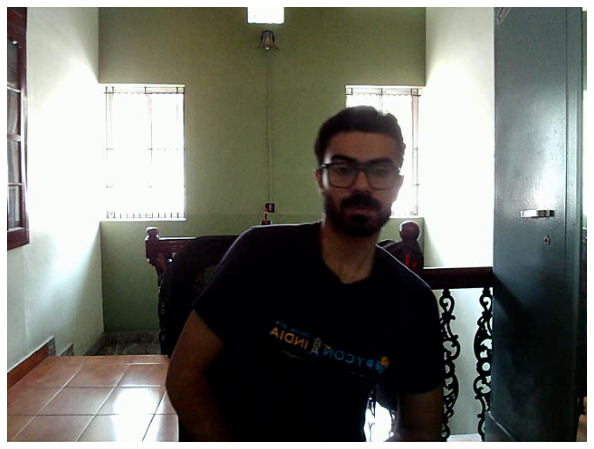

In [44]:
cap = cv2.VideoCapture('output.avi')
cap.set(1, 135)
success, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')

In [45]:
name, dist = matcher.recognize(frame)
name, dist

('Jithin', 0.5744500160217285)